In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
import os
import pickle
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from torchvision.transforms import ToTensor
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix


In [3]:
def load_pickled_ds(fname: str):
    
    with open(fname, 'rb') as f:
        x = pickle.load(f)

    return x

In [4]:
def confussion_matrix(y_val, y_pred):

    counts = np.unique(y_val, return_counts=True)[1]
    class_ratios = np.round(counts / counts.sum(), 3)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    
    cm = confusion_matrix(y_val, y_pred)
    
    ratio_and_names = np.char.add(class_ratios.astype(str), np.char.add(' ', ds_classes))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ds_classes, yticklabels=ratio_and_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [5]:
ds_classes = ['Abies',
              'Acer',
              'Alnus',
              'Betula',
              'Cleared',
              'Fagus',
              'Fraxinus',
              'Larix',
              'Picea',
              'Pinus',
              'Populus',
              'Prunus',
              'Pseudotsuga',
              'Quercus',
              'Tilia']

In [6]:
def compute_sentinel2_indices(data, requested_indices, channel_order):
    """
    Compute vegetation indices and selected Sentinel-2 bands from batched data.

    Parameters:
    - data (numpy array): Input array of shape (Batch, Channels, Width, Height), where
                          Channels are ordered according to Sentinel-2 bands.
    - requested_indices (set): Set of strings specifying desired outputs (e.g., {"NDVI", "R", "G", "EVI"}).
    - channel_order (list): List of strings defining the order of channels in the data.
                            Example: ["B1", "B2", "B3", "B4", ..., "B12"].

    Returns:
    - result (numpy array): Output array of shape (Batch, len(requested_indices), Width, Height),
                            where each channel corresponds to a computed index or band.
    """
    # Map Sentinel-2 bands to their indices in the input array
    channel_map = {band: i for i, band in enumerate(channel_order)}

    # Add shorthand mappings for common RGB bands
    shorthand_map = {
        "B": "B2",  # Blue
        "G": "B3",  # Green
        "R": "B4",  # Red
        "NIR": "B8",  # Near Infrared
        "SWIR1": "B11",  # Shortwave Infrared 1
        "SWIR2": "B12"   # Shortwave Infrared 2
    }

    # Resolve all shorthand indices to full band names
    resolved_indices = {shorthand_map.get(idx, idx) for idx in requested_indices}

    # Prepare output array
    batch_size, _, width, height = data.shape
    result = np.zeros((batch_size, len(requested_indices), width, height))

    # Compute requested indices
    for i, index in enumerate(requested_indices):
        resolved_index = shorthand_map.get(index, index)
        if resolved_index in channel_map:
            # Directly copy specified bands (e.g., "R", "G", etc.)
            result[:, i, :, :] = data[:, channel_map[resolved_index], :, :]
        elif resolved_index == "NDVI":
            # NDVI = (NIR - R) / (NIR + R)
            nir = data[:, channel_map["B8"], :, :]  # NIR (Band 8)
            red = data[:, channel_map["B4"], :, :]  # Red (Band 4)
            result[:, i, :, :] = (nir - red) / (nir + red + 1e-8)
        elif resolved_index == "EVI":
            # EVI = 2.5 * (NIR - R) / (NIR + 6*R - 7.5*B + 1)
            nir = data[:, channel_map["B8"], :, :]
            red = data[:, channel_map["B4"], :, :]
            blue = data[:, channel_map["B2"], :, :]
            result[:, i, :, :] = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1 + 1e-6)
        elif resolved_index == "GNDVI":
            # GNDVI = (NIR - G) / (NIR + G)
            nir = data[:, channel_map["B8"], :, :]
            green = data[:, channel_map["B3"], :, :]
            result[:, i, :, :] = (nir - green) / (nir + green + 1e-6)
        elif resolved_index == "SAVI":
            # SAVI = (NIR - R) * (1 + L) / (NIR + R + L), L=0.5
            nir = data[:, channel_map["B8"], :, :]
            red = data[:, channel_map["B4"], :, :]
            result[:, i, :, :] = ((nir - red) * 1.5) / (nir + red + 0.5 + 1e-6)
        elif resolved_index == "ARVI":
            # ARVI = (NIR - (2*R - B)) / (NIR + (2*R - B))
            nir = data[:, channel_map["B8"], :, :]
            red = data[:, channel_map["B4"], :, :]
            blue = data[:, channel_map["B2"], :, :]
            result[:, i, :, :] = (nir - (2 * red - blue)) / (nir + (2 * red - blue) + 1e-8)
        elif resolved_index == "MSAVI":
            # MSAVI = (2 * NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR - R))) / 2
            nir = data[:, channel_map["B8"], :, :]
            red = data[:, channel_map["B4"], :, :]
            numerator = 2 * nir + 1
            denominator = np.sqrt((2 * nir + 1) ** 2 - 8 * (nir - red)) + 1e-8
            result[:, i, :, :] = (numerator - denominator) / 2
        elif resolved_index == "NDWI":
            # NDWI = (G - NIR) / (G + NIR)
            green = data[:, channel_map["B3"], :, :]
            nir = data[:, channel_map["B8"], :, :]
            result[:, i, :, :] = (green - nir) / (green + nir + 1e-8)
        else:
            raise ValueError(f"Unknown index or band: {index}")

    return result

channel_order = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]


def get_both_train_and_val(X_train, X_val, requested_indices, channel_order = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]):
    X_train_ = compute_sentinel2_indices(X_train, requested_indices, channel_order)
    X_val_ = compute_sentinel2_indices(X_val, requested_indices, channel_order)
    return X_train_, X_val_
    

In [7]:
X_train_s1, y_train_s1, full_distrib_train_s1, X_val_s1, y_val_s1, full_distrib_val_s1 = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s1_60.pkl')
X_train_s2, y_train_s2, full_distrib_train_s2, X_val_s2, y_val_s2, full_distrib_val_s2 = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s2_60.pkl')

s2_plus_ndvi_indexes =  {"B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "NDVI"}
s2_plus_ndvi_evi_indexes =  {"B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "NDVI", "EVI"}
s2_plus_ndvi_evi_ndwi_indexes =  {"B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "NDVI", "EVI", "NDWI"}
s2_only_veg_indexes = {"NDVI", "EVI", "NDWI", "GNDVI", "SAVI", "ARVI", "MSAVI"}

s2_plus_ndvi_train, s2_plus_ndvi_val = get_both_train_and_val(X_train_s2, X_val_s2, s2_plus_ndvi_indexes)
s2_plus_ndvi_evi_train, s2_plus_ndvi_evi_val  = get_both_train_and_val(X_train_s2, X_val_s2, s2_plus_ndvi_evi_indexes)
s2_plus_ndvi_evi_ndwi_train, s2_plus_ndvi_evi_ndwi_val = get_both_train_and_val(X_train_s2, X_val_s2, s2_plus_ndvi_evi_ndwi_indexes)
s2_only_veg_train, s2_only_veg_val = get_both_train_and_val(X_train_s2, X_val_s2, s2_only_veg_indexes)

Text(0.5, 1.0, 'Val_distro')

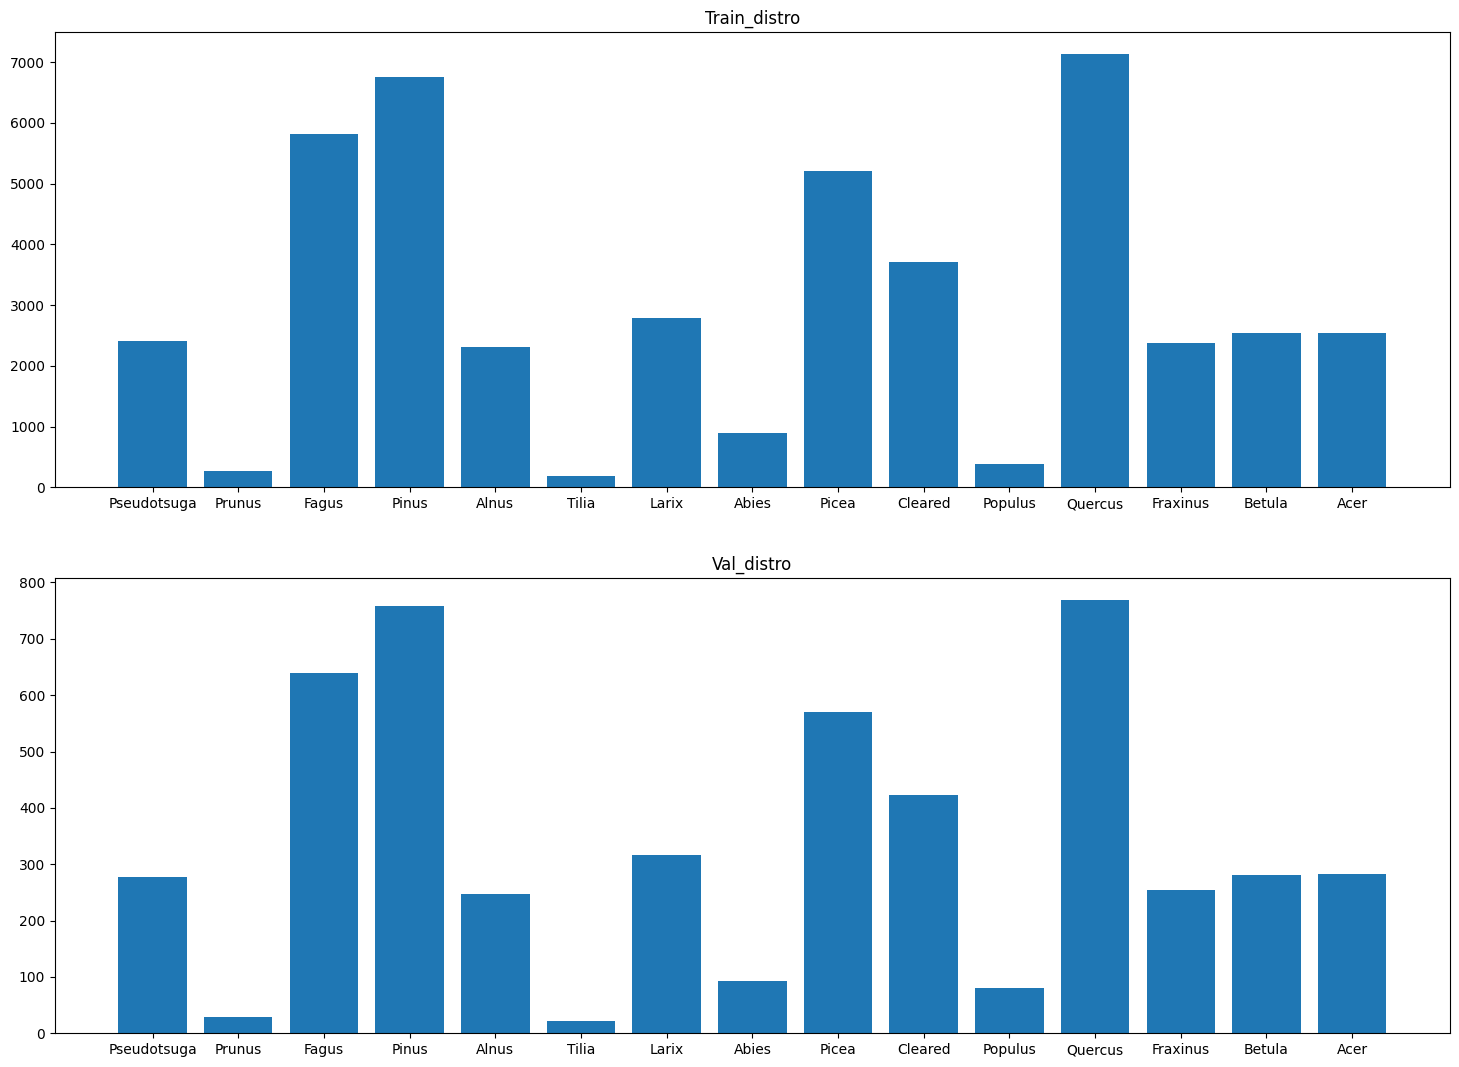

In [8]:

class_names = os.listdir('data/ims/sorted/s1_60m/train/')

class_counts_train = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/train/', class_name))) for class_name in class_names]
class_counts_val = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/test/', class_name))) for class_name in class_names]

f, ax = plt.subplots(2, 1, figsize=(18, 13))

ax[0].bar(class_names, class_counts_train)
ax[0].set_title('Train_distro')

ax[1].bar(class_names, class_counts_val)
ax[1].set_title('Val_distro')

In [9]:
def flatt_train_and_val(train, val):
    return train.reshape(train.shape[0], -1), val.reshape(val.shape[0], -1)

In [10]:
X_train_s1 = X_train_s1.reshape(X_train_s1.shape[0], -1)
X_val_s1 = X_val_s1.reshape(X_val_s1.shape[0], -1)

X_train_s2 = X_train_s2.reshape(X_train_s2.shape[0], -1)
X_val_s2 = X_val_s2.reshape(X_val_s2.shape[0], -1)

X_train_s1s2 = np.hstack((X_train_s1, X_train_s2))
X_val_s1s2 = np.hstack((X_val_s1, X_val_s2))


X_train_s1s2, X_val_s1s2 = flatt_train_and_val(X_train_s1s2, X_val_s1s2)

s2_plus_ndvi_train, s2_plus_ndvi_val = flatt_train_and_val(s2_plus_ndvi_train, s2_plus_ndvi_val)
s2_plus_ndvi_evi_train, s2_plus_ndvi_evi_val = flatt_train_and_val(s2_plus_ndvi_evi_train, s2_plus_ndvi_evi_val)
s2_plus_ndvi_evi_ndwi_train, s2_plus_ndvi_evi_ndwi_val = flatt_train_and_val(s2_plus_ndvi_evi_ndwi_train, s2_plus_ndvi_evi_ndwi_val)
s2_only_veg_train, s2_only_veg_val = flatt_train_and_val(s2_only_veg_train, s2_only_veg_val)

In [11]:
def scaler(train, val):
    sc = StandardScaler()
    train = scaler_s1.fit_transform(train)
    val = scaler_s1.transform(val)
    return train, val

In [12]:
scaler_s1 = StandardScaler()
X_train_s1 = scaler_s1.fit_transform(X_train_s1)
X_val_s1 = scaler_s1.transform(X_val_s1)

scaler_s2 = StandardScaler()
X_train_s2 = scaler_s2.fit_transform(X_train_s2)
X_val_s2 = scaler_s2.transform(X_val_s2)


X_train_s1s2, X_val_s1s2 = scaler(X_train_s1s2, X_val_s1s2)

s2_plus_ndvi_train, s2_plus_ndvi_val = scaler(s2_plus_ndvi_train, s2_plus_ndvi_val)
s2_plus_ndvi_evi_train, s2_plus_ndvi_evi_val = scaler(s2_plus_ndvi_evi_train, s2_plus_ndvi_evi_val)
s2_plus_ndvi_evi_ndwi_train, s2_plus_ndvi_evi_ndwi_val = scaler(s2_plus_ndvi_evi_ndwi_train, s2_plus_ndvi_evi_ndwi_val)
s2_only_veg_train, s2_only_veg_val = scaler(s2_only_veg_train, s2_only_veg_val)

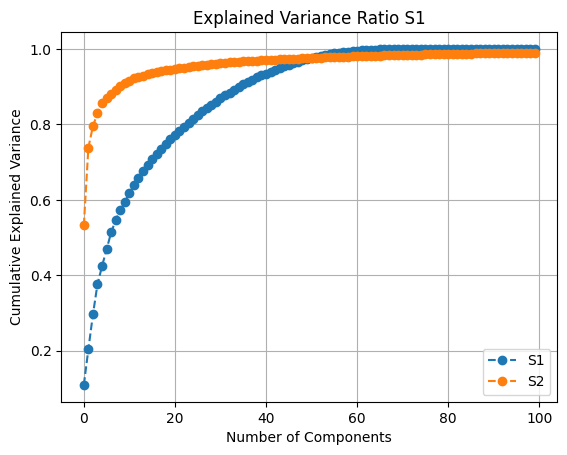

In [13]:
pca_s1 = PCA(n_components=100, svd_solver='full')
pca_s1.fit(X_train_s1)

pca_s2 = PCA(n_components=100, svd_solver='full')
pca_s2.fit(X_train_s2)

plt.plot(np.cumsum(pca_s1.explained_variance_ratio_), marker='o', linestyle='--', label='S1')
plt.plot(np.cumsum(pca_s2.explained_variance_ratio_), marker='o', linestyle='--', label='S2')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio S1')
plt.legend()
plt.grid()

In [14]:
pca_s1_40 = PCA(n_components=35, svd_solver='full')
pca_s1_40.fit(X_train_s1)
X_train_s1_pca = pca_s1_40.transform(X_train_s1)
X_val_s1_pca = pca_s1_40.transform(X_val_s1)


pca_s2_15 = PCA(n_components=15, svd_solver='full')
pca_s2_15.fit(X_train_s2)
X_train_s2_pca = pca_s2_15.transform(X_train_s2)
X_val_s2_pca = pca_s2_15.transform(X_val_s2)

Here we tried classical SVM. But: the dataset has 50k samples and 20 or 40 features. Roughly speaking SVM has O(N^2) complexity. Moreever sklearn computes it on one core, so classical SVM seems not working. At the same time, SVM problem solved with SGD works, see below.

In [15]:
datasets = {
   "raw_s1": (X_train_s1, y_train_s1, X_val_s1, y_val_s1),
   "raw_s2": (X_train_s2, y_train_s2, X_val_s2, y_val_s2),
   "pca40_s1": (X_train_s1_pca, y_train_s1, X_val_s1_pca, y_val_s1),
   "pca15_s2": (X_train_s2_pca, y_train_s2, X_val_s2_pca, y_val_s2),
   "s2_plus_ndvi": (s2_plus_ndvi_train, y_train_s1, s2_plus_ndvi_val, y_val_s1),
   "s2_plus_ndvi_evi": (s2_plus_ndvi_evi_train, y_train_s1, s2_plus_ndvi_evi_val, y_val_s1),
   "s2_plus_ndvi_evi_ndwi": (s2_plus_ndvi_evi_ndwi_train, y_train_s1, s2_plus_ndvi_evi_ndwi_val, y_val_s1),
   "s2_only_veg": (s2_only_veg_train, y_train_s1, s2_only_veg_val, y_val_s1)
}

algos = {
    "svm_l1": SGDClassifier(loss='hinge', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "svm_l2": SGDClassifier(loss='hinge', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    
    "linreg_l1": SGDClassifier(loss='log_loss', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "linreg_l2": SGDClassifier(loss='log_loss', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "perceptron_l1": SGDClassifier(loss='perceptron', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "perceptron_l2": SGDClassifier(loss='perceptron', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "squared_hinge_l1": SGDClassifier(loss='squared_hinge', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=7000, random_state=42, n_jobs=-1),
    "squared_hinge_l2": SGDClassifier(loss='squared_hinge', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=7000, random_state=42, n_jobs=-1),

    "catboost": CatBoostClassifier(
                    iterations=500,       
                    learning_rate=0.01,   
                    depth=6,              
                    verbose=50,           
                    random_seed=42,       
                    task_type='GPU'
                    ) 
}

In [16]:
res = {}

for ds_name, data in datasets.items():
    for algo_name, algo in algos.items():
        X_train, y_train, X_val, y_val = data
        
        algo.fit(X_train, y_train)
        y_pred = algo.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        f1_micro = f1_score(y_val, y_pred, average="micro")
        f1_macro = f1_score(y_val, y_pred, average="macro")

        res[(ds_name, algo_name)] = (accuracy, f1_micro, f1_macro)

%clear
%time

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0:	learn: 2.6998259	total: 22.8ms	remaining: 11.4s
50:	learn: 2.4563159	total: 626ms	remaining: 5.51s
100:	learn: 2.3535206	total: 1.27s	remaining: 5.02s
150:	learn: 2.2983439	total: 1.92s	remaining: 4.44s
200:	learn: 2.2647724	total: 2.5s	remaining: 3.72s
250:	learn: 2.2424713	total: 3.07s	remaining: 3.04s
300:	learn: 2.2263440	total: 3.62s	remaining: 2.39s
350:	learn: 2.2132392	total: 4.17s	remaining: 1.77s
400:	learn: 2.2022496	total: 4.72s	remaining: 1.16s
450:	learn: 2.1924206	total: 5.27s	remaining: 572ms
499:	learn: 2.1835738	total: 5.81s	remaining: 0us
0:	learn: 2.6797885	total: 46.7ms	remaining: 23.3s
50:	learn: 2.0859868	total: 1.88s	remaining: 16.6s
100:	learn: 1.8761552	total: 3.75s	remaining: 14.8s
150:	learn: 1.7613813	total: 5.64s	remaining: 13s
200:	learn: 1.6905146	total: 7.56s	remaining: 11.2s
250:	learn: 1.6435122	total: 9.42s	remaining: 9.34s
300:	learn: 1.6107031	total: 11.2s	remaining: 7.4s
350:	learn: 1.5855877	total: 12.9s	remaining: 5.49s
400:	learn: 1.5643175	

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0:	learn: 2.6797890	total: 49.9ms	remaining: 24.9s
50:	learn: 2.0859870	total: 2.02s	remaining: 17.8s
100:	learn: 1.8761552	total: 4.07s	remaining: 16.1s
150:	learn: 1.7613814	total: 6.11s	remaining: 14.1s
200:	learn: 1.6905141	total: 8.2s	remaining: 12.2s
250:	learn: 1.6435693	total: 10.2s	remaining: 10.1s
300:	learn: 1.6102640	total: 12.1s	remaining: 8.02s
350:	learn: 1.5839200	total: 14.1s	remaining: 5.98s
400:	learn: 1.5610522	total: 16s	remaining: 3.96s
450:	learn: 1.5415872	total: 18s	remaining: 1.96s
499:	learn: 1.5248336	total: 20s	remaining: 0us


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0:	learn: 2.6797892	total: 53.2ms	remaining: 26.6s
50:	learn: 2.0859868	total: 2.15s	remaining: 19s
100:	learn: 1.8761552	total: 4.28s	remaining: 16.9s
150:	learn: 1.7613814	total: 6.45s	remaining: 14.9s
200:	learn: 1.6905144	total: 8.63s	remaining: 12.8s
250:	learn: 1.6435267	total: 10.8s	remaining: 10.7s
300:	learn: 1.6101799	total: 12.8s	remaining: 8.46s
350:	learn: 1.5839084	total: 14.8s	remaining: 6.3s
400:	learn: 1.5615870	total: 16.9s	remaining: 4.17s
450:	learn: 1.5416406	total: 19s	remaining: 2.06s
499:	learn: 1.5246238	total: 21s	remaining: 0us
0:	learn: 2.6788950	total: 62.5ms	remaining: 31.2s
50:	learn: 2.0749695	total: 2.35s	remaining: 20.7s
100:	learn: 1.8636853	total: 4.67s	remaining: 18.4s
150:	learn: 1.7494880	total: 7.01s	remaining: 16.2s
200:	learn: 1.6799860	total: 9.36s	remaining: 13.9s
250:	learn: 1.6348131	total: 11.6s	remaining: 11.5s
300:	learn: 1.6024000	total: 13.8s	remaining: 9.12s
350:	learn: 1.5766546	total: 16s	remaining: 6.78s
400:	learn: 1.5547301	total

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0:	learn: 2.6940947	total: 30ms	remaining: 15s
50:	learn: 2.3414114	total: 1.22s	remaining: 10.7s
100:	learn: 2.2064444	total: 2.37s	remaining: 9.37s
150:	learn: 2.1364529	total: 3.55s	remaining: 8.2s
200:	learn: 2.0956955	total: 4.71s	remaining: 7s
250:	learn: 2.0690763	total: 5.86s	remaining: 5.82s
300:	learn: 2.0504670	total: 7.01s	remaining: 4.63s
350:	learn: 2.0358137	total: 8.15s	remaining: 3.46s
400:	learn: 2.0236184	total: 9.29s	remaining: 2.29s
450:	learn: 2.0125062	total: 10.4s	remaining: 1.13s
499:	learn: 2.0031006	total: 11.5s	remaining: 0us
CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.1 μs


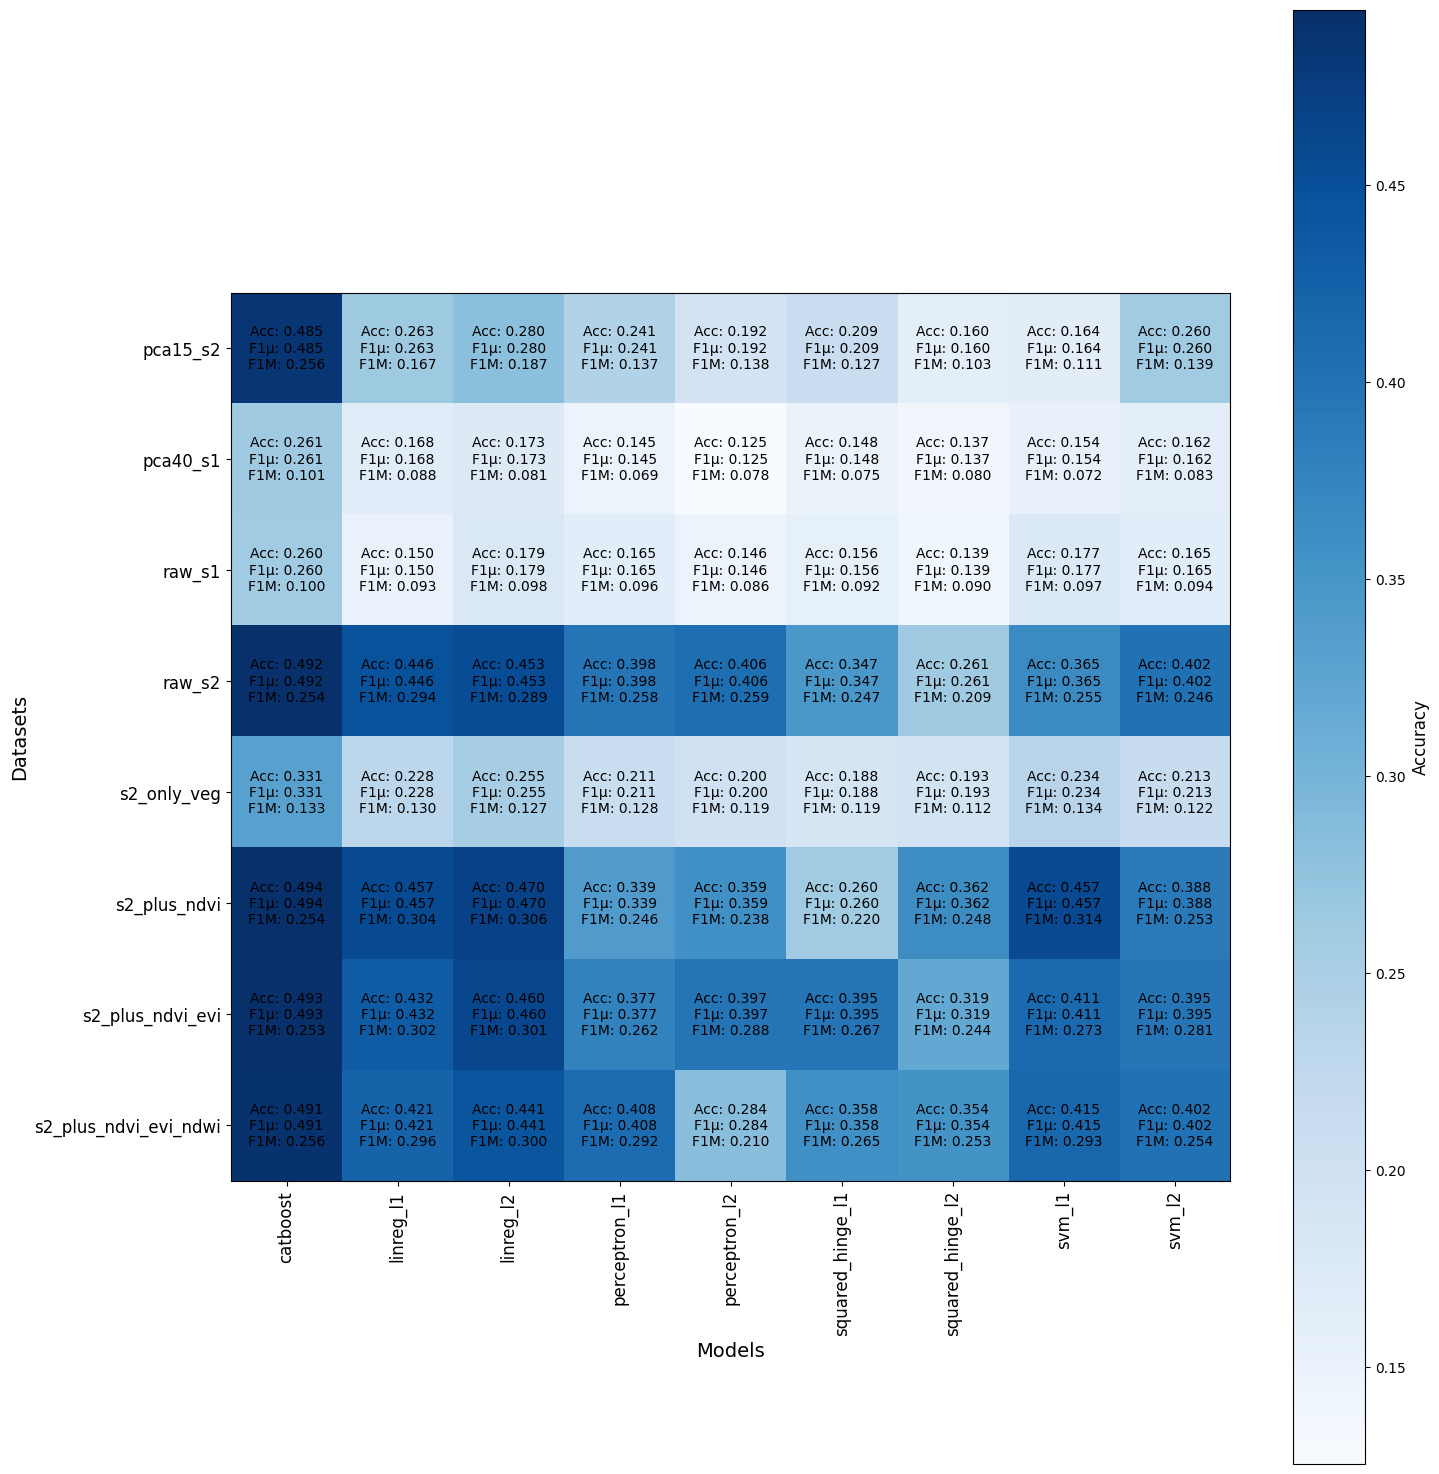

In [17]:
# Extract unique dataset and model names
datasets = sorted(set(key[0] for key in res.keys()))
models = sorted(set(key[1] for key in res.keys()))

# Create a matrix to store accuracy, F1 micro, and F1 macro
matrix = np.empty((len(datasets), len(models)), dtype=object)

# Fill the matrix with res
for (dataset, model), metrics in res.items():
    row = datasets.index(dataset)
    col = models.index(model)
    accuracy, f1_micro, f1_macro = metrics
    matrix[row, col] = f"Acc: {accuracy:.3f}\nF1µ: {f1_micro:.3f}\nF1M: {f1_macro:.3f}"

# Plot the matrix
fig, ax = plt.subplots(figsize=(15, 15))

# Use a heatmap for visualization
heatmap = np.zeros_like(matrix, dtype=float)  # Placeholder for color intensity
for row in range(len(datasets)):
    for col in range(len(models)):
        heatmap[row, col] = res[(datasets[row], models[col])][0]  # Use accuracy for intensity

im = ax.imshow(heatmap, cmap="Blues")

# Add annotations
for i in range(len(datasets)):
    for j in range(len(models)):
        ax.text(j, i, matrix[i, j], ha="center", va="center", fontsize=10, color="black")

# Set axis labels
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(datasets)))
ax.set_xticklabels(models, fontsize=12, rotation=90)
ax.set_yticklabels(datasets, fontsize=12)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Datasets", fontsize=14)

# Add a colorbar to indicate accuracy intensity
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Accuracy", fontsize=12)

plt.tight_layout()
plt.show()